A first attempt at getting a working LGBM Model running

- The best LGBM model is pickled to 'model/best_LGBM.pkl'
- The best XGBOOST model is pickled to 'model/best_XGBOOST.pkl'

# IMPORTS

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import RidgeClassifier

import xgboost as xgb
from xgboost.sklearn import XGBRegressor, XGBClassifier

from lightgbm import LGBMClassifier

import re
import gc
import joblib

import warnings
warnings.filterwarnings("ignore")

# READ DATA

The data used here has been preprocessed by the file '01 HDCR Data Preprocess'

In [8]:
USE_SAMPLE_DATA = True

if USE_SAMPLE_DATA:
    print ('Using saved data')
    df = pd.read_csv('testdata/hdcr10k.csv')
else:
    print ('Using FULL data')
    # df = pd.read_csv('../data/cleaned/hcdr_FULL.csv',nrows=10000)
    df = pd.read_csv('../data/cleaned/hcdr_FULL.csv')

df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

df.shape

Using saved data


(20000, 767)

In [9]:
df = df[~df.TARGET.isna()]
df.TARGET.value_counts(dropna=False)

0.0    9225
1.0     775
Name: TARGET, dtype: int64

In [10]:
print (df.isna().sum().sum())

5392502


# IMPUTE NaN

! SimpleImputer drops columns consisting entirely of missing values !

Solution is to drop these columns beforehand, or to not include them in the imputation

In [11]:
num_rows = df.shape[0]

lst_empty_cols = []
for column in df.columns:
    if df[column].isnull().sum() == num_rows:
        lst_empty_cols.append(column)
df = df.drop(columns = lst_empty_cols)

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

# NO LONGER NEEDED HERE AS IT IS DONE IN THE PREVIOUS NOTEBOOK

if df.isna().sum().sum() > 0:
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    imputer = SimpleImputer(missing_values=np.nan, strategy = 'median')
    df=pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)

    # Scale the features
    # scaler = MinMaxScaler(feature_range = (0, 1))
    # df=pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)


In [9]:
print (df.isna().sum().sum())

0


# X and y

In [13]:
X= df.drop('TARGET',axis=1)
y= df['TARGET']

print (df.TARGET.value_counts(dropna=False))

print (X.shape)
print (y.shape)

0.0    9225
1.0     775
Name: TARGET, dtype: int64
(10000, 749)
(10000,)


# SPLIT TEST/TRAIN

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1234)

print ('X_train',X_train.shape)
print ('X_test ',X_test.shape)
print ('y_train',y_train.shape)
print ('y_test ',y_test.shape)


X_train (7000, 749)
X_test  (3000, 749)
y_train (7000,)
y_test  (3000,)


# GridSearch Functions

In [15]:
def init_results():
    return pd.DataFrame(columns=['classifier','grid_score','score','params'])

def add_result(results,classifier,grid_score,score,params):
    new_row = {'classifier':classifier, 'grid_score':grid_score, 'score':score, 'params':params}
    return results.append(new_row, ignore_index=True)

def show_results(results):
    print(results.sort_values('score', ascending=False))

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

def run_gridsearch(model_name, model, params, folds, X_train, y_train, X_test, y_test, verbosity):
    print ('Running GridSearchCV for',model_name)
    grid = GridSearchCV(model, params, scoring='roc_auc', cv=folds, verbose=verbosity)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    grid_score = grid.best_score_
    best_model.fit(X_train, y_train)
    y_predict = best_model.predict(X_test)
    auc_score = roc_auc_score(y_test,y_predict)
    return grid_score, auc_score, best_params, best_model


In [16]:
results = init_results()

In [17]:
folds = KFold(n_splits= 5, shuffle=True, random_state=1001)

# XGBClassifier

# LGBMClassifier

In [16]:
lstModelParams = [
    [
        'LGBMClassifier',
        LGBMClassifier(), 
        {   'n_estimators': [100],
            'learning_rate':[0.1,0.02],
            'num_leaves':[34,40],
            'colsample_bytree':[0.9497036],
            'subsample':[0.8715623],
            'max_depth':[5, 8],
            'reg_alpha':[0.041545473],
            'reg_lambda':[0.0735294],
            'min_split_gain':[0.0222415],
            'min_child_weight':[39.3259775]
        }
    ],

    [
        'XGBClassifier',
        xgb.XGBClassifier(), 
        {
            'nthread':[4], #when use hyperthread, xgboost may become slower
            'objective':['binary:logistic'],
            'learning_rate': [0.05], #so called `eta` value
            'max_depth': [6],
            'min_child_weight': [11],
            'silent': [1],
            'subsample': [0.8],
            'colsample_bytree': [0.7],
            'n_estimators': [5], #number of trees, change it to 1000 for better results
            'missing':[-999],
            'seed': [1337],
            'silent':[1]
        }
    ],
]

for x in lstModelParams:
    model_name = x[0]
    model = x[1]
    params = x[2]
    verbosity = 3
    grid_score, auc_score, best_params, best_model = run_gridsearch(model_name, model, params, folds, X_train, y_train, X_test, y_test, verbosity)
    results = add_result(results,model_name,grid_score,auc_score,best_params)
    joblib.dump(best_model, 'model/best_' + model_name + '.pkl')



Running GridSearchCV for LGBMClassifier
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END colsample_bytree=0.9497036, learning_rate=0.1, max_depth=5, min_child_weight=39.3259775, min_split_gain=0.0222415, n_estimators=100, num_leaves=34, reg_alpha=0.041545473, reg_lambda=0.0735294, subsample=0.8715623;, score=0.774 total time=   0.4s
[CV 2/5] END colsample_bytree=0.9497036, learning_rate=0.1, max_depth=5, min_child_weight=39.3259775, min_split_gain=0.0222415, n_estimators=100, num_leaves=34, reg_alpha=0.041545473, reg_lambda=0.0735294, subsample=0.8715623;, score=0.765 total time=   0.3s
[CV 3/5] END colsample_bytree=0.9497036, learning_rate=0.1, max_depth=5, min_child_weight=39.3259775, min_split_gain=0.0222415, n_estimators=100, num_leaves=34, reg_alpha=0.041545473, reg_lambda=0.0735294, subsample=0.8715623;, score=0.754 total time=   0.3s
[CV 4/5] END colsample_bytree=0.9497036, learning_rate=0.1, max_depth=5, min_child_weight=39.3259775, min_split_gain=0.0222

In [70]:
lstModelParams = [
    [
        'GradientBoostingClassifier',
        GradientBoostingClassifier(), 
        {
            'n_estimators': [200],
            'learning_rate':[0.1,0.02],
            'max_depth':[1, 3]
        }
    ],
]

for x in lstModelParams:
    model_name = x[0]
    model = x[1]
    params = x[2]
    verbosity = 3
    grid_score, auc_score, best_params, best_model = run_gridsearch(model_name, model, params, folds, X_train, y_train, X_test, y_test, verbosity)
    results = add_result(results,model_name,grid_score,auc_score,best_params)
    joblib.dump(best_model, 'model/best_' + model_name + '.pkl')


Running GridSearchCV for GradientBoostingClassifier
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END learning_rate=0.1, max_depth=1, n_estimators=200;, score=0.764 total time=   6.0s
[CV 2/5] END learning_rate=0.1, max_depth=1, n_estimators=200;, score=0.752 total time=   5.5s
[CV 3/5] END learning_rate=0.1, max_depth=1, n_estimators=200;, score=0.768 total time=   5.5s
[CV 4/5] END learning_rate=0.1, max_depth=1, n_estimators=200;, score=0.775 total time=   5.5s
[CV 5/5] END learning_rate=0.1, max_depth=1, n_estimators=200;, score=0.738 total time=   5.6s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.754 total time=  15.8s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.738 total time=  15.9s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.754 total time=  15.7s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=200;, score=0.736 total time=  16.7s
[CV 5/5] END learning_rate=0.1, m

# ExtraTrees

In [71]:
lstModelParams = [
    [
        'ExtraTreesClassifier_unbalanced',
        ExtraTreesClassifier(), 
        {
            'n_estimators': [100,200],
            'min_samples_leaf':[1,2],
            'min_weight_fraction_leaf':[0.0, 0.1]
        }
    ],
    [
        'ExtraTreesClassifier_balanced',
        ExtraTreesClassifier(class_weight='balanced'), 
        {
            'n_estimators': [100,200],
            'min_samples_leaf':[1,2],
            'min_weight_fraction_leaf':[0.0, 0.1]
        }
    ],
]

for x in lstModelParams:
    model_name = x[0]
    model = x[1]
    params = x[2]
    verbosity = 3
    grid_score, auc_score, best_params, best_model = run_gridsearch(model_name, model, params, folds, X_train, y_train, X_test, y_test, verbosity)
    results = add_result(results,model_name,grid_score,auc_score,best_params)
    joblib.dump(best_model, 'model/best_' + model_name + '.pkl')

Running GridSearchCV for ExtraTreesClassifier_unbalanced
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END min_samples_leaf=1, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.708 total time=   1.8s
[CV 2/5] END min_samples_leaf=1, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.669 total time=   1.8s
[CV 3/5] END min_samples_leaf=1, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.670 total time=   1.8s
[CV 4/5] END min_samples_leaf=1, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.689 total time=   1.9s
[CV 5/5] END min_samples_leaf=1, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.719 total time=   2.6s
[CV 1/5] END min_samples_leaf=1, min_weight_fraction_leaf=0.0, n_estimators=200;, score=0.714 total time=   4.5s
[CV 2/5] END min_samples_leaf=1, min_weight_fraction_leaf=0.0, n_estimators=200;, score=0.677 total time=   4.4s
[CV 3/5] END min_samples_leaf=1, min_weight_fraction_leaf=0.0, n_estimators=200;, score=0.67

# RandomForestClassifier, DecisionTreeClassifier, ExtraTreeClassifier

In [72]:
lstModelParams = [
    [
        'RandomForestClassifier_unbalanced',
        RandomForestClassifier(), 
        {
            'n_estimators': [100,200],
            'min_samples_leaf':[1,2],
            'min_weight_fraction_leaf':[0.0, 0.1]
        }
    ],
    [
        'RandomForestClassifier_balanced',
        RandomForestClassifier(class_weight='balanced'), 
        {
            'n_estimators': [100,200],
            'min_samples_leaf':[1,2],
            'min_weight_fraction_leaf':[0.0, 0.1]
        }
    ],

    [
        'DecisionTreeClassifier_unbalanced',
        DecisionTreeClassifier(), 
        {
            'splitter': ['best','random'],
            'min_samples_leaf':[1,2],
            'min_weight_fraction_leaf':[0.0, 0.1]
        }
    ],
    [
        'DecisionTreeClassifier_balanced',
        DecisionTreeClassifier(class_weight='balanced'), 
        {
            'splitter': ['best','random'],
            'min_samples_leaf':[1,2],
            'min_weight_fraction_leaf':[0.0, 0.1]
        }
    ],

    [
        'ExtraTreeClassifier_unbalanced',
        ExtraTreeClassifier(), 
        {
            'splitter': ['best','random'],
            'min_samples_leaf':[1,2],
            'min_weight_fraction_leaf':[0.0, 0.1]
        }
    ],
    [
        'ExtraTreeClassifier_balanced',
        ExtraTreeClassifier(class_weight='balanced'), 
        {
            'splitter': ['best','random'],
            'min_samples_leaf':[1,2],
            'min_weight_fraction_leaf':[0.0, 0.1]
        }
    ],
]

for x in lstModelParams:
    model_name = x[0]
    model = x[1]
    params = x[2]
    verbosity = 3
    grid_score, auc_score, best_params, best_model = run_gridsearch(model_name, model, params, folds, X_train, y_train, X_test, y_test, verbosity)
    results = add_result(results,model_name,grid_score,auc_score,best_params)
    joblib.dump(best_model, 'model/best_' + model_name + '.pkl')

Running GridSearchCV for RandomForestClassifier_unbalanced
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END min_samples_leaf=1, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.728 total time=   2.0s
[CV 2/5] END min_samples_leaf=1, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.693 total time=   1.8s
[CV 3/5] END min_samples_leaf=1, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.698 total time=   1.8s
[CV 4/5] END min_samples_leaf=1, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.717 total time=   1.8s
[CV 5/5] END min_samples_leaf=1, min_weight_fraction_leaf=0.0, n_estimators=100;, score=0.684 total time=   1.8s
[CV 1/5] END min_samples_leaf=1, min_weight_fraction_leaf=0.0, n_estimators=200;, score=0.734 total time=   3.8s
[CV 2/5] END min_samples_leaf=1, min_weight_fraction_leaf=0.0, n_estimators=200;, score=0.705 total time=   3.7s
[CV 3/5] END min_samples_leaf=1, min_weight_fraction_leaf=0.0, n_estimators=200;, score=0.

In [73]:
results.sort_values('score', ascending=False)

,classifier,grid_score,score,params
4,ExtraTreesClassifier_balanced,0.701479,0.649669,"{'min_samples_leaf': 1, 'min_weight_fraction_l..."
8,DecisionTreeClassifier_balanced,0.704167,0.636243,"{'min_samples_leaf': 1, 'min_weight_fraction_l..."
10,ExtraTreeClassifier_balanced,0.602331,0.570923,"{'min_samples_leaf': 1, 'min_weight_fraction_l..."
2,GradientBoostingClassifier,0.759353,0.512938,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti..."
0,LGBMClassifier,0.757829,0.507110,"{'colsample_bytree': 0.9497036, 'learning_rate..."
6,RandomForestClassifier_balanced,0.723862,0.503645,"{'min_samples_leaf': 2, 'min_weight_fraction_l..."
3,ExtraTreesClassifier_unbalanced,0.709326,0.500000,"{'min_samples_leaf': 2, 'min_weight_fraction_l..."
5,RandomForestClassifier_unbalanced,0.721646,0.500000,"{'min_samples_leaf': 1, 'min_weight_fraction_l..."
7,DecisionTreeClassifier_unbalanced,0.692909,0.500000,"{'min_samples_leaf': 1, 'min_weight_fraction_l..."
9,ExtraTreeClassifier_unbalanced,0.565433,0.500000,"{'min_samples_leaf': 2, 'min_weight_fraction_l..."


# CLASS IMBALANCE

## With no balancing

In [80]:
# not balanced 
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
target = 'TARGET'
print(pd.crosstab(pd.Series(y_predict, name='Predicted'), pd.Series(y_test, name='Actual')))

# balanced 
model = DecisionTreeClassifier(class_weight='balanced')
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
target = 'TARGET'
print(pd.crosstab(pd.Series(y_predict, name='Predicted'), pd.Series(y_test, name='Actual')))


Actual     0.0  1.0
Predicted          
0.0        763   62
1.0         88    5
Actual     0.0  1.0
Predicted          
0.0        783   64
1.0         68    3


# Finding the balance

In [105]:
weights = np.linspace(0.05, 0.95, 30)
model = DecisionTreeClassifier()
params = {'class_weight': [{0:x, 1: 1.0-x} for x in weights]}
grid = GridSearchCV(model, params, scoring='f1', cv=folds, verbose=2)
grid_results = grid.fit(X_train, y_train)
print ('Best Params: ', grid_results.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ....................class_weight={0: 0.05, 1: 0.95}; total time=   0.4s
[CV] END ....................class_weight={0: 0.05, 1: 0.95}; total time=   0.3s
[CV] END ....................class_weight={0: 0.05, 1: 0.95}; total time=   0.3s
[CV] END ....................class_weight={0: 0.05, 1: 0.95}; total time=   0.3s
[CV] END ....................class_weight={0: 0.05, 1: 0.95}; total time=   0.3s
[CV] END class_weight={0: 0.08103448275862069, 1: 0.9189655172413793}; total time=   0.3s
[CV] END class_weight={0: 0.08103448275862069, 1: 0.9189655172413793}; total time=   0.3s
[CV] END class_weight={0: 0.08103448275862069, 1: 0.9189655172413793}; total time=   0.3s
[CV] END class_weight={0: 0.08103448275862069, 1: 0.9189655172413793}; total time=   0.3s
[CV] END class_weight={0: 0.08103448275862069, 1: 0.9189655172413793}; total time=   0.3s
[CV] END class_weight={0: 0.11206896551724138, 1: 0.8879310344827587}; total time= 

<AxesSubplot:xlabel='weight'>

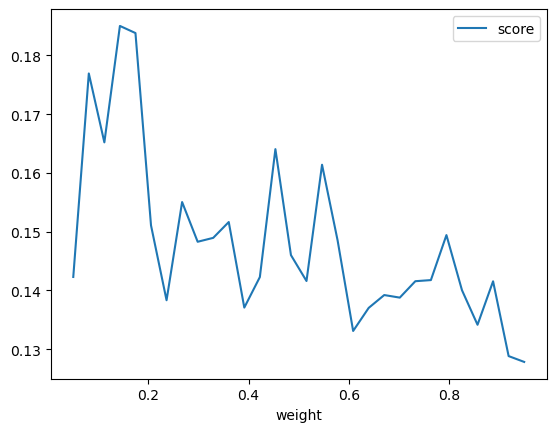

In [106]:
data_out = pd.DataFrame({'score': grid_results.cv_results_['mean_test_score'],'weight': weights})
data_out.plot(x='weight')

In [107]:
data_out

,score,weight
0,0.142292,0.050000
1,0.176934,0.081034
2,0.165204,0.112069
3,0.185031,0.143103
4,0.183816,0.174138
5,0.151072,0.205172
6,0.138325,0.236207
7,0.155045,0.267241
8,0.148283,0.298276
9,0.148947,0.329310


In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [51]:
def generate_model_report(y_actual, y_predicted):
    print("Accuracy = " , accuracy_score(y_actual, y_predicted))
    print("Precision = " ,precision_score(y_actual, y_predicted))
    print("Recall = " ,recall_score(y_actual, y_predicted))
    print("F1 Score = " ,f1_score(y_actual, y_predicted))
    pass

def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass



In [108]:
model = DecisionTreeClassifier(**grid_results.best_params_).fit(X_train,y_train)
y_predict = model.predict(X_test)
pd.crosstab(pd.Series(y_predict, name='Predicted'), pd.Series(y_test, name='Actual'))


Actual,0.0,1.0
Predicted,,
0.0,786,67
1.0,65,0


In [109]:
generate_model_report(y_test, y_predict)

Accuracy =  0.873
Precision =  0.18067226890756302
Recall =  0.18777292576419213
F1 Score =  0.1841541755888651


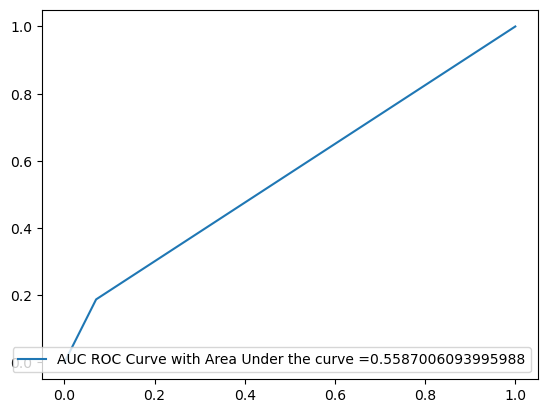

In [111]:
generate_auc_roc_curve(model, X_test)

# SMOTE

In [16]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline


In [17]:
unique, count = np.unique(y_train, return_counts=True)
Y_train_dict_value_count = { k:v for (k,v) in zip(unique, count)}
Y_train_dict_value_count

{0.0: 6454, 1.0: 546}

In [19]:
sm = SMOTE(random_state=12, sampling_strategy = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)


In [20]:
unique, count = np.unique(y_train_res, return_counts=True)
y_train_smote_value_count = { k:v for (k,v) in zip(unique, count)}
y_train_smote_value_count

{0.0: 6454, 1.0: 6454}

In [21]:
clf = DecisionTreeClassifier().fit(x_train_res, y_train_res)

In [22]:
Y_Test_Pred = clf.predict(X_test)

pd.crosstab(pd.Series(Y_Test_Pred, name = 'Predicted'), 
            pd.Series(y_test, name = 'Actual'))

Actual,0.0,1.0
Predicted,,
0.0,765,53
1.0,86,14


In [23]:
generate_model_report(y_test, Y_Test_Pred)

Accuracy =  0.828
Precision =  0.1046831955922865
Recall =  0.16593886462882096
F1 Score =  0.12837837837837837


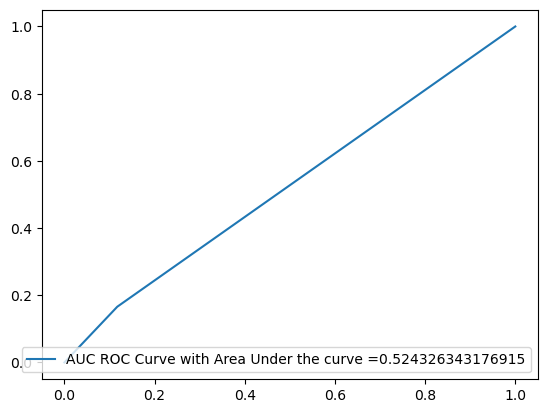

In [24]:
generate_auc_roc_curve(clf, X_test)

In [25]:
weights = np.linspace(0.005, 0.25, 10)
weights

array([0.005     , 0.03222222, 0.05944444, 0.08666667, 0.11388889,
       0.14111111, 0.16833333, 0.19555556, 0.22277778, 0.25      ])

Best parameters : {'smote__sampling_strategy': 0.1411111111111111}


<AxesSubplot:xlabel='weight'>

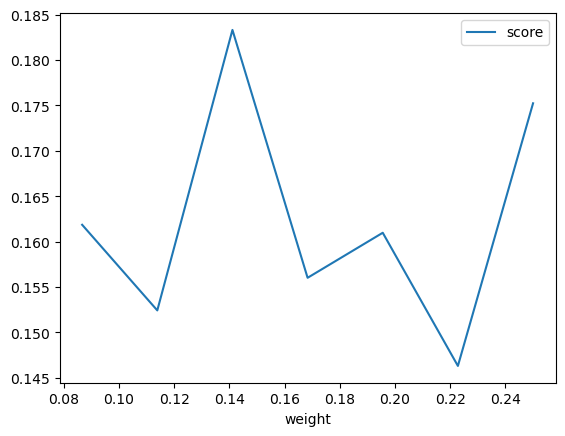

In [27]:
pipe = make_pipeline(
    SMOTE(),
    DecisionTreeClassifier()
)

weights = np.linspace(0.005, 0.25, 10)

gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        'smote__sampling_strategy': weights
    },
    scoring='f1',
    cv=3
)
grid_result = gsc.fit(X_train, y_train)

print("Best parameters : %s" % grid_result.best_params_)
weight_f1_score_df = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                                   'weight': weights })
weight_f1_score_df.plot(x='weight')

In [28]:
pipe = make_pipeline(
    SMOTE(sampling_strategy=0.1411111111111111),
    DecisionTreeClassifier()
)

pipe.fit(X_train, y_train)

Y_Test_Pred = pipe.predict(X_test)

In [29]:
pd.crosstab(pd.Series(Y_Test_Pred, name = 'Predicted'), 
            pd.Series(y_test, name = 'Actual'))

Actual,0.0,1.0
Predicted,,
0.0,773,55
1.0,78,12


In [30]:
generate_model_report(y_test, Y_Test_Pred)

Accuracy =  0.8503333333333334
Precision =  0.14052287581699346
Recall =  0.18777292576419213
F1 Score =  0.16074766355140188


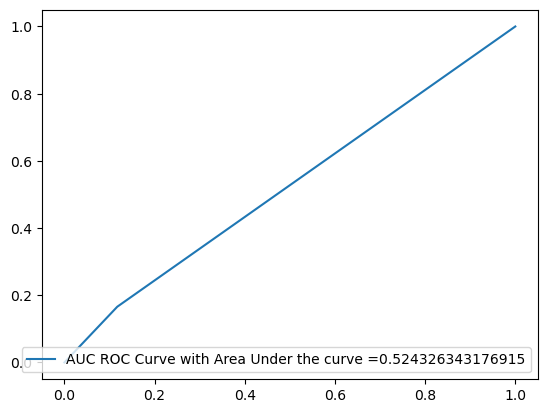

In [31]:
generate_auc_roc_curve(clf, X_test)

# UNDERSAMPLING
https://github.com/bhattbhavesh91/imbalance_class_sklearn/blob/master/imbalance_class_undersampling_oversampling.ipynb

In [32]:
minority_class_len = len(df[df['TARGET'] == 1])
print(minority_class_len)

775


In [33]:
majority_class_indices = df[df['TARGET'] == 0].index
print(majority_class_indices)

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999],
           dtype='int64', length=9225)


In [37]:
random_majority_indices = np.random.choice(majority_class_indices,
                                           minority_class_len, 
                                           replace=False)
print(len(random_majority_indices))

775


In [38]:
minority_class_indices = df[df['TARGET'] == 1].index
print(minority_class_indices)

Int64Index([   0,   26,   40,   42,   81,   94,  110,  138,  154,  163,
            ...
            9876, 9880, 9920, 9923, 9924, 9925, 9930, 9953, 9965, 9984],
           dtype='int64', length=775)


In [39]:
under_sample_indices = np.concatenate([minority_class_indices,random_majority_indices])

In [40]:
under_sample = df.loc[under_sample_indices]

<AxesSubplot:xlabel='TARGET', ylabel='count'>

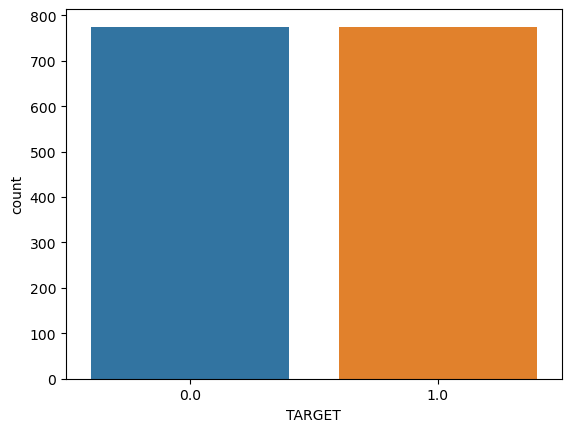

In [42]:
sns.countplot(x='TARGET', data=under_sample)

In [53]:
X = under_sample.loc[:, df.columns!='TARGET']
Y = under_sample.loc[:, df.columns=='TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
clf = DecisionTreeClassifier().fit(X_train, y_train)
Y_Test_Pred = clf.predict(X_test)

In [54]:
generate_model_report(y_test, Y_Test_Pred)

Accuracy =  0.6171875
Precision =  0.6091954022988506
Recall =  0.6284584980237155
F1 Score =  0.6186770428015563


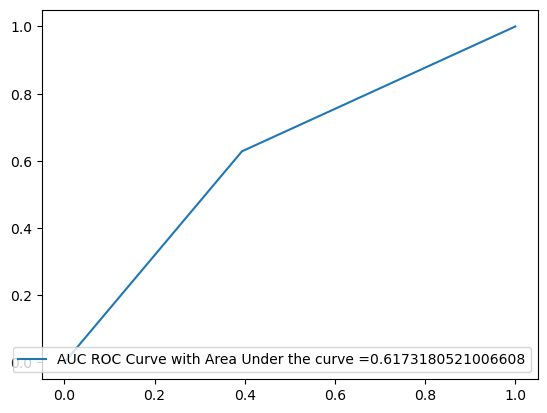

In [55]:
generate_auc_roc_curve(clf, X_test)